## Setup

In [ ]:
! pip install neuralogic
from neuralogic.core import Template, R, V
from neuralogic.dataset import Dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
template = Template()

# GNN-like graph propagation
template +=  R.layer_1(V.X) <= (R.bond(V.X, V.Y, V.B))

### Dataset definition

In [ ]:
train_dataset = Dataset()
train_dataset.add_example(
    [
        R.o(1), R.h(2), R.h(3), # water
        R.bond(1, 2, 10), R.bond(1, 3, 11),
        R.b_1(10), R.b_1(11)
    ],
)
train_dataset.add_example(
    [
        R.o(1), R.h(2), R.h(3), R.h(4), R.h(5), R.c(6), # methanol
        R.bond(1, 2, 10), R.bond(6, 3, 11), R.bond(6, 4, 12), R.bond(6, 5, 13),
        R.b_1(10), R.b_1(11), R.b_1(12), R.b_1(13)
    ],
)

## Bonding rules

In [ ]:
## check bonding rules if working well

template += R.single_bonded(V.X, V.Y) <= (R.bond(V.X, V.Y, V.B), R.b_1(V.B))
template += R.single_bonded(V.X, V.Y) <= (R.bond(V.Y, V.X, V.B), R.b_1(V.B))

template += R.double_bonded(V.X, V.Y) <= (R.bond(V.X, V.Y, V.B), R.b_2(V.B))
template += R.double_bonded(V.X, V.Y) <= (R.bond(V.Y, V.X, V.B), R.b_2(V.B))

template += R.triple_bonded(V.X, V.Y) <= (R.bond(V.X, V.Y, V.B), R.b_3(V.B))
template += R.triple_bonded(V.X, V.Y) <= (R.bond(V.Y, V.X, V.B), R.b_3(V.B))


# aromatic, ionic, ...
template += R.aromatic_bonded(V.X, V.Y) <= (R.bond(V.X, V.Y, V.B), R.b_4(V.B))
template += R.aromatic_bonded(V.X, V.Y) <= (R.bond(V.Y, V.X, V.B), R.b_4(V.B)) # or which nuber

## Saturation

In [ ]:
from neuralogic.core import Aggregation

template += R.saturated(V.X) <= (R.c(V.X),
                                 R.single_bonded(V.X, V.Y1),
                                 R.single_bonded(V.X, V.Y2),
                                 R.single_bonded(V.X, V.Y3),
                                 R.single_bonded(V.X, V.Y4),
                                 R.special.alldiff(...)) # with alldiff it doesn't work
template += (R.saturated <= (R.saturated(V.X))) | [Aggregation.MIN]

Carbonyl

In [ ]:
# carbonyl group contains a carbon double bonded with oxygen
template += R.carbonyl(V.Mol) <= (R.contains(V.Mol, V.C), R.contains(V.Mol, V.O), R.carbonyl_group(V.O, V.C))
template += R.carbonyl_group(V.C, V.O) <= (R.c(V.C), R.o(V.O), R.double_bonded(V.O, V.C))
template += R.carbonyl_group(V.C, V.O, V.R1, V.R2) <= (R.c(V.C), R.o(V.O), R.double_bonded(V.O, V.C), R.single_bonded(V.C, V.R1), R.single_bonded(V.C, V.R2))

## Nitrogen groups

Amines

In [ ]:
template += R.amino(V.N, V.C, V.R1, V.R2) <= (~R.carbonyl_group(V.C, _), R.amino_group(V.N, V.C, V.R1, V.R2))
template += R.amino_group(V.N, V.R1, V.R2, V.R3) <= (R.c(V.R1), R.n(V.N), R.single_bonded(V.N, V.R1), R.single_bonded(V.N, V.R2), R.single_bonded(V.N, V.R3))

In [ ]:
template += R.amine(V.Mol) <= R.primary_amine(V.Mol)
template += R.amine(V.Mol) <= R.secondary_amine(V.Mol)
template += R.amine(V.Mol) <= R.tertiary_amine(V.Mol)
template += R.amine(V.Mol) <= R.quat_ammonion(V.Mol)

template += R.primary_amine(V.Mol) <= (R.contains(V.Mol, V.C), R.contains(V.Mol, V.N), R.amino(V.N, V.C, V.R1, V.R2), R.h(V.R1), R.h(V.R2))
template += R.secondary_amine(V.Mol) <= (R.contains(V.Mol, V.C), R.contains(V.Mol, V.N), R.amino(V.N, V.C, V.R1, V.R2), R.h(V.R1), ~R.h(V.R2))
template += R.tertiary_amine(V.Mol) <= (R.contains(V.Mol, V.C), R.contains(V.Mol, V.N), R.amino(V.N, V.C, V.R1, V.R2), ~R.h(V.R1), ~R.h(V.R2))
template += R.quat_ammonion(V.Mol) <= (R.contains(V.Mol, V.N), R.quat_ammonion(V.N, _, _, _, _))
template += R.quat_ammonion(V.N, V.C1, V.C2, V.C3, V.C4) <= (R.n(V.N), R.c(V.C1), R.c(V.C2), R.c(V.C3), R.c(V.C4), 
                                                              R.single_bonded(V.N, V.C1), R.single_bonded(V.N, V.C2), 
                                                              R.single_bonded(V.N, V.C3), R.single_bonded(V.N, V.C4))

Amides

In [ ]:
template += R.amide(V.Mol) <= (R.contains(V.Mol, V.C), R.contains(V.Mol, V.N), R.amide(V.N, V.C))

template += R.amide(V.N, V.C) <= (R.carbonyl_group(V.C, _, V.R, V.N),
                                  R.amino_group(V.N, V.C, V.R1, V.R2))

Imines

In [ ]:
template += R.imine_group(V.C, V.N) <= (R.imine_group(V.C, V.N, _, _, _))
template += R.imine_group(V.C, V.N, V.R, V.R1, V.R2) <= (R.c(V.C), R.n(V.N), R.double_bonded(V.C, V.N), R.single_bonded(V.C, V.R1), R.single_bonded(V.C, V.R2), R.single_bonded(V.N, V.R))


In [ ]:
template += R.imine(V.Mol) <= R.ketimine(V.Mol)
template += R.imine(V.Mol) <= R.aldimine(V.Mol)

template += R.ketimine(V.Mol) <= R.primary_ketimine()

template += R.primary_amine(V.Mol) <= (R.contains(V.Mol, V.C), R.contains(V.Mol, V.N), R.amino(V.N, V.C, V.R1, V.R2), R.h(V.R1), R.h(V.R2))
template += R.secondary_amine(V.Mol) <= (R.contains(V.Mol, V.C), R.contains(V.Mol, V.N), R.amino(V.N, V.C, V.R1, V.R2), R.h(V.R1), ~R.h(V.R2))
template += R.tertiary_amine(V.Mol) <= (R.contains(V.Mol, V.C), R.contains(V.Mol, V.N), R.amino(V.N, V.C, V.R1, V.R2), ~R.h(V.R1), ~R.h(V.R2))
template += R.quat_ammonion(V.Mol) <= (R.contains(V.Mol, V.N), R.quat_ammonion(V.N, _, _, _, _))
template += R.quat_ammonion(V.N, V.C1, V.C2, V.C3, V.C4) <= (R.n(V.N), R.c(V.C1), R.c(V.C2), R.c(V.C3), R.c(V.C4), 
                                                              R.single_bonded(V.N, V.C1), R.single_bonded(V.N, V.C2), 
                                                              R.single_bonded(V.N, V.C3), R.single_bonded(V.N, V.C4))

Amidines

## Predicition

layer_1(X) :- bond(X, Y, B).
single_bonded(X, Y) :- bond(X, Y, B), b_1(B).
single_bonded(X, Y) :- bond(Y, X, B), b_1(B).
saturated(X) :- c(X), single_bonded(X, Y1), single_bonded(X, Y2), single_bonded(X, Y3), single_bonded(X, Y4).
saturated :- saturated(X). [aggregation=min]
{1} predict :- layer_1(X).
{1} predict :- saturated(X).


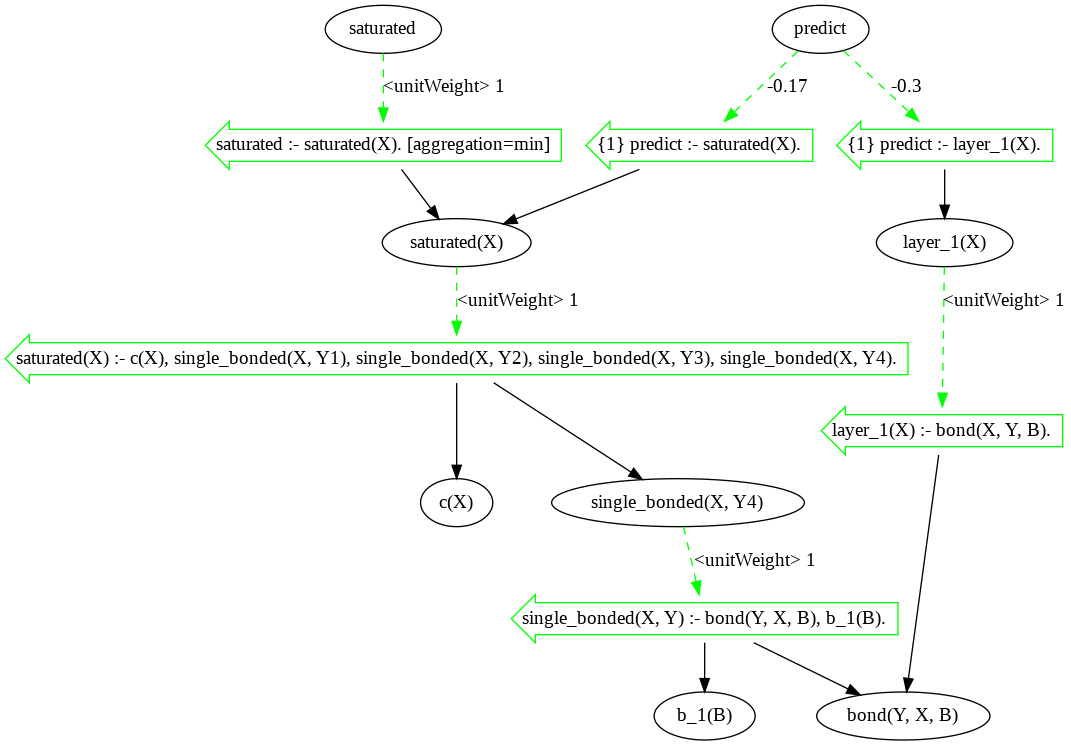

In [ ]:
template += R.predict[1,] <= R.layer_1(V.X)
template += R.predict[1,] <= R.saturated(V.X)

train_dataset.add_queries([
    R.predict[0],
    R.predict[1],
])
print(template)
template.draw()

## Training

In [ ]:
from neuralogic.core import Settings
from neuralogic.nn.loss import MSE, CrossEntropy
from neuralogic.nn import get_evaluator
from neuralogic.optim import Adam

settings = Settings(optimizer=Adam(lr=0.1), epochs=100, error_function=CrossEntropy())
evaluator = get_evaluator(template, settings)

built_dataset = evaluator.build_dataset(train_dataset)

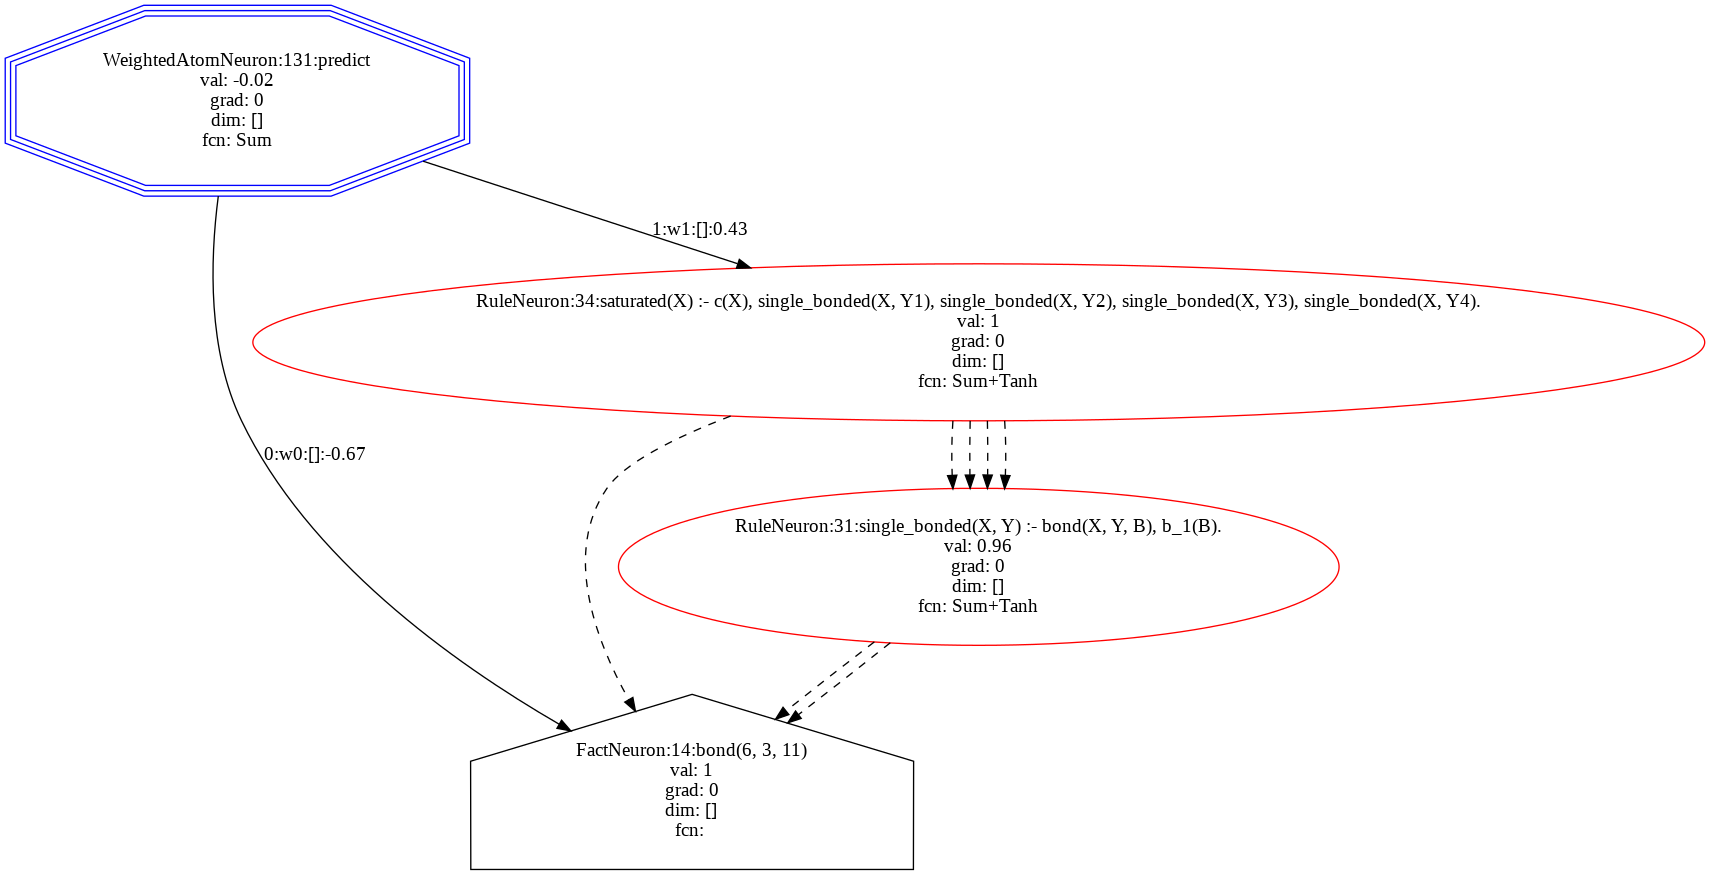

In [ ]:
built_dataset[1].draw()

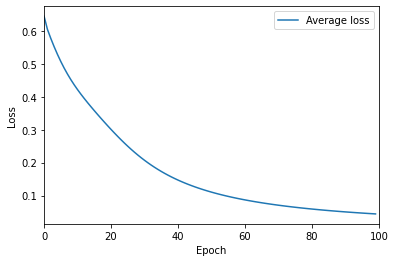

In [ ]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

average_losses = []

for current_total_loss, number_of_samples in evaluator.train(built_dataset):
    clear_output(wait=True)
    plt.ylabel("Loss")
    plt.xlabel("Epoch")

    plt.xlim(0, settings.epochs)

    average_losses.append(current_total_loss / number_of_samples)
    
    plt.plot(average_losses, label="Average loss")

    plt.legend()
    plt.pause(0.001)
    plt.show()

In [ ]:
for sample, y_hat in zip(built_dataset.samples, evaluator.test(built_dataset)):
    print(f"Target: {sample.java_sample.target}, Predicted: {round(y_hat)} ({y_hat})")

Target: 0, Predicted: -3 (-2.832615017579885)
Target: 1, Predicted: 3 (3.4884432389781943)
